In [13]:
import pandas as pd
enformer_preds = "/mnt/lab_data2/anusri/chrombpnet/results/variant_data/dsqtls/process/with_wnformer_preds.csv"

In [14]:
scores = pd.read_csv(enformer_preds,header=None)
scores[0] = scores[0].str.replace("b'","").str.replace("'","")

In [15]:
dnase_preds="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/dsqtl_preds/snp_scores.tsv"
dsqtls_dnase = pd.read_csv(dnase_preds,sep="\t", header=0, index_col=False)
dsqtls_dnase[['gkm_SVM','kmer_SVM','abs_gkm_SVM','abs_kmer_SVM','CADD','GWAVA_region','GWAVA_tss','GWAVA_unmatched','GERP','label']] = dsqtls_dnase['META_DATA'].str.split(",", expand=True)


In [16]:
atac_preds="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/dsqtl_preds/snp_scores.tsv"
dsqtls_atac = pd.read_csv(atac_preds,sep="\t", header=0, index_col=False)
dsqtls_atac[['gkm_SVM','kmer_SVM','abs_gkm_SVM','abs_kmer_SVM','CADD','GWAVA_region','GWAVA_tss','GWAVA_unmatched','GERP','label']] = dsqtls_dnase['META_DATA'].str.split(",", expand=True)


In [17]:
dsqtls_dnase["rsid"] = dsqtls_dnase["CHR"] + "_" + dsqtls_dnase["POS0"].astype(str) + "_" + dsqtls_dnase["REF"] + "_" + dsqtls_dnase["ALT"]

In [18]:
dsqtls_atac["rsid"] = dsqtls_atac["CHR"] + "_" + dsqtls_atac["POS0"].astype(str) + "_" + dsqtls_atac["REF"] + "_" + dsqtls_atac["ALT"]



In [19]:
#dsqtls_atac.shape

In [20]:
snps=pd.read_csv("/mnt/lab_data3/anusri/histone_expts/all_qtl_analysis/gm12878_sequence_sets/test_set/deltasv,/41588_2015_BFng3331_MOESM26_ESM.csv",header=0,sep=',')
df = pd.DataFrame()
df['label'] = snps["label"].astype(int)
df['abs_gkm_SVM'] = snps["abs_gkm_SVM"].astype(str)
df['rsid'] = snps["SNPname2"].astype(str)
df["Chr"] = snps["chrom_hg18"].astype(str) 
df["Pos0"] = snps["pos_hg18"].astype(int) - 1
df['POSTallele']= snps["allele1"].astype(str)
df['ALTallele']= snps["allele2"].astype(str)
df['rsid2'] = df["Chr"] + "_" + df["Pos0"].astype(str) + "_" + df["POSTallele"] + "_" + df["ALTallele"] 
df['META']=snps[['gkm_SVM','kmer_SVM','abs_gkm_SVM','abs_kmer_SVM','CADD','GWAVA_region','GWAVA_tss','GWAVA_unmatched','GERP','label']].astype(str).agg(','.join, axis=1)


In [21]:
df.shape

(28309, 9)

In [22]:
merged = df.merge(scores,left_on="rsid",right_on=0, how="inner")

In [23]:
merged.shape

(25262, 12)

In [24]:
scores.shape

(25262, 3)

In [25]:
merged_with_atac = merged.merge(dsqtls_atac,left_on="rsid2",right_on='rsid', how="inner").drop_duplicates()
merged = merged.merge(dsqtls_dnase,left_on="rsid2",right_on='rsid', how="inner").drop_duplicates()


In [26]:
merged_with_atac.columns

Index([               'label_x',          'abs_gkm_SVM_x',
                       'rsid_x',                    'Chr',
                         'Pos0',             'POSTallele',
                    'ALTallele',                  'rsid2',
                         'META',                        0,
                              1,                        2,
                          'CHR',                   'POS0',
                          'REF',                    'ALT',
                    'META_DATA',        'log_counts_diff',
       'log_probs_diff_abs_sum',         'probs_jsd_diff',
                      'gkm_SVM',               'kmer_SVM',
                'abs_gkm_SVM_y',           'abs_kmer_SVM',
                         'CADD',           'GWAVA_region',
                    'GWAVA_tss',        'GWAVA_unmatched',
                         'GERP',                'label_y',
                       'rsid_y'],
      dtype='object')

25262 516


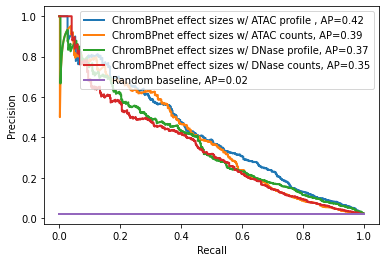

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import random
import os
import argparse
from sklearn.metrics import precision_recall_curve


fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_with_atac["label_x"], abs(merged_with_atac["probs_jsd_diff"]))
roc_auc = metrics.average_precision_score(merged_with_atac["label_x"], abs(merged_with_atac["probs_jsd_diff"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPnet effect sizes w/ ATAC profile , AP="+str(round(roc_auc,2)))

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_with_atac["label_x"], abs(merged_with_atac["log_counts_diff"]))
roc_auc = metrics.average_precision_score(merged_with_atac["label_x"], abs(merged_with_atac["log_counts_diff"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPnet effect sizes w/ ATAC counts, AP="+str(round(roc_auc,2)))


fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged["label_x"], abs(merged["probs_jsd_diff"]))
roc_auc = metrics.average_precision_score(merged["label_x"], abs(merged["probs_jsd_diff"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPnet effect sizes w/ DNase profile, AP="+str(round(roc_auc,2)))

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged["label_x"], abs(merged["log_counts_diff"]))
roc_auc = metrics.average_precision_score(merged["label_x"], abs(merged["log_counts_diff"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPnet effect sizes w/ DNase counts, AP="+str(round(roc_auc,2)))

in1 = list(merged["label_x"])
random.shuffle(in1)
in1=np.array(in1)

fpr_random, tpr_random, _ = precision_recall_curve(merged["label_x"], in1)
roc_auc = metrics.average_precision_score(merged["label_x"], in1)
plt.plot(tpr_random, [sum(merged["label_x"]==1)/len(merged["label_x"])]*len(fpr_random), linewidth=2, label="Random baseline, AP="+str(round(roc_auc,2)))


print(len(merged["label_x"]), sum(merged["label_x"]==1))
plt.legend(loc='upper right')
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.savefig("subfigs/pr_curve_chrombpnet_only.pdf", transparent=True, dpi=300)


In [30]:
new_scores = pd.read_csv("/mnt/lab_data2/anusri/dsqtl_ensemble/dsqtls_ensemble.csv",header=0)

In [36]:
new_scores.head()

,labels,preds
0,1,0.062765
1,1,0.006343
2,1,0.024529
3,1,0.325149
4,1,0.012742


In [37]:
new_scores_dnase = pd.read_csv("/mnt/lab_data2/anusri/dsqtl_ensemble/dsqtls_ensemble_dnase.csv",header=0)

25262 516


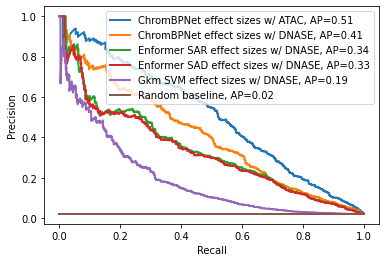

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import random
import os
import argparse
from sklearn.metrics import precision_recall_curve


#fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged_with_atac["label_x"], abs(merged_with_atac["probs_jsd_diff"]))
#roc_auc = metrics.average_precision_score(merged_with_atac["label_x"], abs(merged_with_atac["probs_jsd_diff"]))
#plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPnet effect sizes w/ ATAC, AP="+str(round(roc_auc,2)))


#fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged["label_x"], abs(merged["probs_jsd_diff"]))
#roc_auc = metrics.average_precision_score(merged["label_x"], abs(merged["probs_jsd_diff"]))
#plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPnet effect sizes w/ DNASE, AP="+str(round(roc_auc,2)))

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(new_scores["labels"], abs(new_scores["preds"]))
roc_auc = metrics.average_precision_score(new_scores["labels"], abs(new_scores["preds"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPNet effect sizes w/ ATAC, AP="+str(round(roc_auc,2)))

fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(new_scores_dnase["labels"], abs(new_scores_dnase["preds"]))
roc_auc = metrics.average_precision_score(new_scores_dnase["labels"], abs(new_scores_dnase["preds"]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="ChromBPNet effect sizes w/ DNASE, AP="+str(round(roc_auc,2)))


fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged["label_x"], abs(merged[2]))
roc_auc = metrics.average_precision_score(merged["label_x"], abs(merged[2]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="Enformer SAR effect sizes w/ DNASE, AP="+str(round(roc_auc,2)))


fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged["label_x"], abs(merged[1]))
roc_auc = metrics.average_precision_score(merged["label_x"], abs(merged[1]))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="Enformer SAD effect sizes w/ DNASE, AP="+str(round(roc_auc,2)))






fpr_chrombpnet, tpr_chrombpnet, _ = precision_recall_curve(merged["label_x"], abs(merged['abs_gkm_SVM_y'].astype(float)))
roc_auc = metrics.average_precision_score(merged["label_x"], abs(merged['abs_gkm_SVM_y'].astype(float)))
plt.plot(tpr_chrombpnet,fpr_chrombpnet,  linewidth=2, label="Gkm SVM effect sizes w/ DNASE, AP="+str(round(roc_auc,2)))


in1 = list(merged["label_x"])
random.shuffle(in1)
in1=np.array(in1)

fpr_random, tpr_random, _ = precision_recall_curve(merged["label_x"], in1)
roc_auc = metrics.average_precision_score(merged["label_x"], in1)
plt.plot(tpr_random, [sum(merged["label_x"]==1)/len(merged["label_x"])]*len(fpr_random), linewidth=2, label="Random baseline, AP="+str(round(roc_auc,2)))


print(len(merged["label_x"]), sum(merged["label_x"]==1))
plt.legend(loc='upper right')
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.savefig("subfigs/benchmarking_new.pdf", transparent=True, dpi=300)


In [28]:
dsqtls = merged[merged["label_x"]==1]
ndsqtls = merged[~(merged["label_x"]==1)].sample(1000)


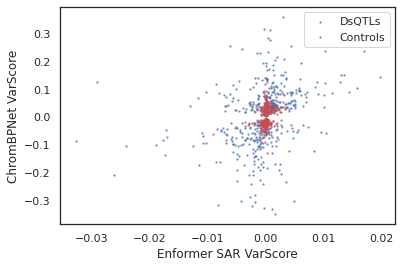

In [29]:
#plt.scatter(abs(dsqtls[2]),abs(dsqtls["probs_jsd_diff"]))
import seaborn as sns
sns.set(style='white')
plt.scatter(dsqtls[2],dsqtls["probs_jsd_diff"]*-1,c="b",alpha=0.8,label="DsQTLs",linewidths=0,s=5)
plt.scatter(ndsqtls[2],ndsqtls["probs_jsd_diff"]*-1,c="r",alpha=0.8,label="Controls",linewidths=0,s=5)
plt.legend(loc='upper right')
plt.xlabel("Enformer SAR VarScore")
plt.ylabel("ChromBPNet VarScore")
plt.savefig("subfigs/chrombpnet_versus_enformer.pdf", transparent=True, dpi=300)


Index([               'label_x',          'abs_gkm_SVM_x',
                       'rsid_x',                    'Chr',
                         'Pos0',             'POSTallele',
                    'ALTallele',                  'rsid2',
                         'META',                        0,
                              1,                        2,
                          'CHR',                   'POS0',
                          'REF',                    'ALT',
                    'META_DATA',        'log_counts_diff',
       'log_probs_diff_abs_sum',         'probs_jsd_diff',
                      'gkm_SVM',               'kmer_SVM',
                'abs_gkm_SVM_y',           'abs_kmer_SVM',
                         'CADD',           'GWAVA_region',
                    'GWAVA_tss',        'GWAVA_unmatched',
                         'GERP',                'label_y',
                       'rsid_y'],
      dtype='object')


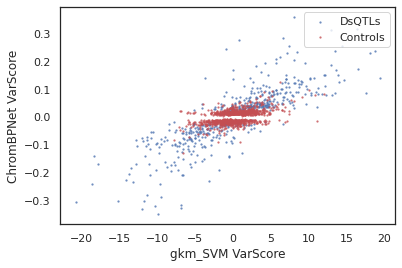

In [30]:
#plt.scatter(abs(dsqtls[2]),abs(dsqtls["probs_jsd_diff"]))
print(dsqtls.columns)
plt.figure()
plt.scatter(dsqtls["gkm_SVM"].astype(float),dsqtls["probs_jsd_diff"]*-1,c="b",alpha=0.8,label="DsQTLs",linewidths=0,s=5)
plt.scatter(ndsqtls["gkm_SVM"].astype(float),ndsqtls["probs_jsd_diff"]*-1,c="r",alpha=0.8,label="Controls",linewidths=0,s=5)
plt.legend(loc='upper right')
plt.xlabel("gkm_SVM VarScore")
plt.ylabel("ChromBPNet VarScore")

plt.savefig("subfigs/chrombpnet_versus_deltasvm.pdf", transparent=True, dpi=300)


In [79]:
dsqtls[dsqtls["probs_jsd_diff"]>0.3].loc[:,"gkm_SVM"]

21     -6.7954289999999995
46               -6.783504
173             -10.222351
185             -20.754752
206    -11.789375999999999
440    -15.184854999999999
463              -9.851068
477             -11.985853
Name: gkm_SVM, dtype: object

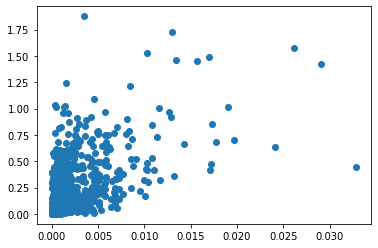

In [31]:
plt.scatter(abs(dsqtls[2]),abs(dsqtls["log_counts_diff"]))


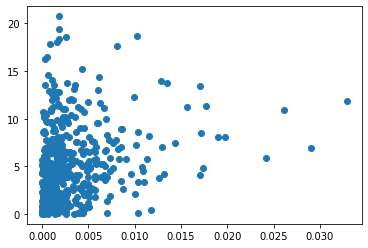

In [26]:
plt.scatter(abs(dsqtls[2]),abs(dsqtls["abs_gkm_SVM_y"].astype(float)))

In [19]:
dsqtls[""]

,label_x,abs_gkm_SVM_x,rsid_x,Chr,Pos0,POSTallele,ALTallele,rsid2,META,0,...,kmer_SVM,abs_gkm_SVM_y,abs_kmer_SVM,CADD,GWAVA_region,GWAVA_tss,GWAVA_unmatched,GERP,label_y,rsid_y
0,1,0.66898,rs10794743,chr10,1401285,A,C,chr10_1401285_A_C,"-0.66898,-2.681439,0.66898,2.681439,-0.506497,...",rs10794743,...,-2.681439,0.66898,2.681439,-0.506497,0.37,0.3,0.29,-3.93,1,chr10_1401285_A_C
1,1,1.372879,rs34174118,chr10,1442536,A,G,chr10_1442536_A_G,"1.372879,0.674,1.372879,0.674,0.02544,0.26,0.2...",rs34174118,...,0.674,1.3728790000000002,0.674,0.02544,0.26,0.27,0.1,0.0465,1,chr10_1442536_A_G
2,1,5.092465,rs11819695,chr10,5927284,T,C,chr10_5927284_T_C,"-5.092465,-4.977196,5.092465,4.977196,-1.16630...",rs11819695,...,-4.977196,5.092465,4.977196,-1.166307,0.34,0.4,0.43,-0.451,1,chr10_5927284_T_C
3,1,6.876955,rs10905307,chr10,5934505,A,G,chr10_5934505_A_G,"6.876955,2.646129,6.876955,2.646129,0.606074,0...",rs10905307,...,2.646129,6.876955000000001,2.646129,0.606074,0.44,0.42,0.48,-0.542,1,chr10_5934505_A_G
4,1,6.679947,rs141802172,chr10,12506802,A,G,chr10_12506802_A_G,"6.679947,13.059399,6.679947,13.059399,-0.66969...",rs141802172,...,13.059399,6.679947,13.059399,-0.669696,0.29,0.12,0.1,0.0,1,chr10_12506802_A_G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,1,4.271205,rs3847193,chr9,132758989,G,A,chr9_132758989_G_A,"4.271205,-2.073453,4.271205,2.073453,-0.247289...",rs3847193,...,-2.0734529999999998,4.271205,2.0734529999999998,-0.24728899999999998,0.46,0.37,0.49,-0.212,1,chr9_132758989_G_A
512,1,10.95599,rs74734156,chr9,134981039,G,A,chr9_134981039_G_A,"-10.95599,-11.360226,10.95599,11.360226,0.0123...",rs74734156,...,-11.360225999999999,10.95599,11.360225999999999,0.012338,0.44,0.4,0.59,-5.6,1,chr9_134981039_G_A
513,1,8.944194,rs2519112,chr9,135801567,A,G,chr9_135801567_A_G,"-8.944194,-14.98855,8.944194,14.98855,0.272977...",rs2519112,...,-14.98855,8.944194,14.98855,0.272977,0.3,0.27,0.32,1.23,1,chr9_135801567_A_G
514,1,4.130903,rs10116708,chr9,139496488,G,A,chr9_139496488_G_A,"4.130903,8.453805,4.130903,8.453805,-0.389886,...",rs10116708,...,8.453805000000001,4.130903,8.453805000000001,-0.389886,0.53,0.57,0.6,-0.89,1,chr9_139496488_G_A
